## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
        OneHotEncoder ,
        MinMaxScaler,
    PowerTransformer,FunctionTransformer,StandardScaler,OrdinalEncoder
)
from sklearn.base import BaseEstimator,TransformerMixin
from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from sklearn.compose import ColumnTransformer
from feature_engine.encoding import (
    RareLabelEncoder,MeanEncoder,CountFrequencyEncoder)
import warnings

C:\Users\Owner\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
!pip install feature_engine

## 2. Display Settings

In [3]:
pd.set_option("display.max_columns",None)


In [4]:
sklearn.set_config(transform_output="pandas")

In [5]:
warnings.filterwarnings("ignore")

## 3. Read the Data

In [6]:
path=r"D:\DS_ML\Flight-AWS_sagemaker_project\Data\train.csv"

train=pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-05-27,Delhi,Cochin,20:55:00,12:35:00,940,1,In-flight meal not included,12898
1,Jet Airways,2019-06-12,Kolkata,Banglore,18:55:00,16:20:00,1285,1,No Info,13044
2,Air India,2019-05-18,Delhi,Cochin,09:45:00,09:25:00,1420,2,No Info,10975
3,Indigo,2019-06-03,Mumbai,Hyderabad,21:20:00,22:50:00,90,0,No Info,2227
4,Jet Airways,2019-04-01,Mumbai,Hyderabad,02:55:00,04:20:00,85,0,No Info,5678
...,...,...,...,...,...,...,...,...,...,...
6689,Spicejet,2019-06-09,Kolkata,Banglore,11:35:00,18:50:00,435,1,No Info,8479
6690,Multiple Carriers,2019-05-09,Delhi,Cochin,10:00:00,01:30:00,930,1,No Info,15078
6691,Air India,2019-05-18,Delhi,Cochin,12:00:00,07:40:00,1180,2,No Info,8603
6692,Air Asia,2019-05-18,Delhi,Cochin,07:55:00,13:25:00,330,1,No Info,8759


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6694 entries, 0 to 6693
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   airline          6694 non-null   object
 1   date_of_journey  6694 non-null   object
 2   source           6694 non-null   object
 3   destination      6694 non-null   object
 4   dep_time         6694 non-null   object
 5   arrival_time     6694 non-null   object
 6   duration         6694 non-null   int64 
 7   total_stops      6694 non-null   int64 
 8   additional_info  6694 non-null   object
 9   price            6694 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 523.1+ KB


In [8]:
X_train=train.drop(columns="price")
y_train=train.price.copy()

## 4. Transformation Operations

### 4.1 Airline


In [9]:
X_train.airline

0             Jet Airways
1             Jet Airways
2               Air India
3                  Indigo
4             Jet Airways
              ...        
6689             Spicejet
6690    Multiple Carriers
6691            Air India
6692             Air Asia
6693    Multiple Carriers
Name: airline, Length: 6694, dtype: object

In [10]:
air_transformer=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("grouper",RareLabelEncoder(tol=.1,replace_with="Other",n_categories=2)),
    ("encoder",OneHotEncoder(sparse_output=False,handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:,["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
6689,0.0,0.0,0.0,0.0,1.0
6690,0.0,0.0,0.0,1.0,0.0
6691,1.0,0.0,0.0,0.0,0.0
6692,0.0,0.0,0.0,0.0,1.0


### 4.2 date_of_journey

In [11]:
feature_to_extract=["month","week","day_of_week","day_of_year"]

doj_transformer=Pipeline(steps=[
    ("dt",DatetimeFeatures(features_to_extract=feature_to_extract,yearfirst=True,format="mixed")),
    ("scalar",MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:,["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.666667,0.764706,0.000000,0.737288
1,1.000000,0.882353,0.333333,0.872881
2,0.666667,0.647059,0.833333,0.661017
3,1.000000,0.823529,0.000000,0.796610
4,0.333333,0.294118,0.000000,0.262712
...,...,...,...,...
6689,1.000000,0.823529,1.000000,0.847458
6690,0.666667,0.588235,0.500000,0.584746
6691,0.666667,0.647059,0.833333,0.661017
6692,0.666667,0.647059,0.833333,0.661017


### 4.3 source $ destination

In [12]:
location_subset=X_train.loc[:,["source","destination"]]
location_subset

,source,destination
0,Delhi,Cochin
1,Kolkata,Banglore
2,Delhi,Cochin
3,Mumbai,Hyderabad
4,Mumbai,Hyderabad
...,...,...
6689,Kolkata,Banglore
6690,Delhi,Cochin
6691,Delhi,Cochin
6692,Delhi,Cochin


In [13]:
location_pipeline1=Pipeline(steps=[
    ("grouper",RareLabelEncoder(tol=0.1,replace_with="Other",n_categories=2)),
    ("encoder",MeanEncoder()),
    ("scaler",PowerTransformer())
    ])
location_pipeline1.fit_transform(location_subset,y_train)

,source,destination
0,1.040187,1.039963
1,-0.190314,-0.185612
2,1.040187,1.039963
3,-1.915733,-0.892199
4,-1.915733,-0.892199
...,...,...
6689,-0.190314,-0.185612
6690,1.040187,1.039963
6691,1.040187,1.039963
6692,1.040187,1.039963


In [14]:
np.union1d(X_train.source.unique(),X_train.destination.unique())

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [15]:
def isNorth(X):
    columns=X.columns.to_list()
    north_cities=["Delhi","Kolkata",'Mumbai', 'New Delhi']
    return(
        X
        .assign(**{
            f"{col}_is_north":X.loc[:,col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
        )
FunctionTransformer(func=isNorth).fit_transform(location_subset)  

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
6689,1,0
6690,1,0
6691,1,0
6692,1,0


In [16]:
location_tranformer=FeatureUnion(transformer_list=[
    ("part1",location_pipeline1),
    ("part2",FunctionTransformer(func=isNorth))
])

location_tranformer.fit_transform(location_subset,y_train)

,source,destination,source_is_north,destination_is_north
0,1.040187,1.039963,1,0
1,-0.190314,-0.185612,1,0
2,1.040187,1.039963,1,0
3,-1.915733,-0.892199,1,0
4,-1.915733,-0.892199,1,0
...,...,...,...,...
6689,-0.190314,-0.185612,1,0
6690,1.040187,1.039963,1,0
6691,1.040187,1.039963,1,0
6692,1.040187,1.039963,1,0


### 4.4 dep_time and arrival_time

In [17]:
time_subset=X_train.loc[:,["dep_time","arrival_time"]]
time_subset

,dep_time,arrival_time
0,20:55:00,12:35:00
1,18:55:00,16:20:00
2,09:45:00,09:25:00
3,21:20:00,22:50:00
4,02:55:00,04:20:00
...,...,...
6689,11:35:00,18:50:00
6690,10:00:00,01:30:00
6691,12:00:00,07:40:00
6692,07:55:00,13:25:00


In [18]:
time_pipe1=Pipeline(steps=[
    ("dt",DatetimeFeatures(features_to_extract=["hour","minute"])),
    ("scaler",MinMaxScaler())
])
time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.869565,1.000000,0.521739,0.636364
1,0.782609,1.000000,0.695652,0.363636
2,0.391304,0.818182,0.391304,0.454545
3,0.913043,0.363636,0.956522,0.909091
4,0.086957,1.000000,0.173913,0.363636
...,...,...,...,...
6689,0.478261,0.636364,0.782609,0.909091
6690,0.434783,0.000000,0.043478,0.545455
6691,0.521739,0.000000,0.304348,0.727273
6692,0.304348,1.000000,0.565217,0.454545


In [19]:
def part_of_day(X,morning=4,noon=12,eve=16,night=20):
    columns=X.columns.to_list()
    X_temp=X.assign(**{
    col:pd.to_datetime(X.loc[:,col]).dt.hour
    for col in columns
    })
    return(
    X_temp
    .assign(**{
        f"{col}_part_of_day":np.select(
        [X_temp.loc[:,col].between(morning,noon,inclusive="left"),
         X_temp.loc[:,col].between(noon,eve,inclusive="left"),
         X_temp.loc[:,col].between(eve,night,inclusive="left")],
            ["morning","afternoon","evening"],
            default="night"
        )
    
        for col in columns
        
    })
     .drop(columns=columns)  
    )
FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,night,afternoon
1,evening,evening
2,morning,morning
3,night,night
4,night,morning
...,...,...
6689,morning,evening
6690,morning,night
6691,afternoon,morning
6692,morning,afternoon


In [20]:
time_pipe2=Pipeline(steps=[
    ("part",FunctionTransformer(func=part_of_day)),
    ("encoder",CountFrequencyEncoder()),
    ("scaler",MinMaxScaler())
])
time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,0.159827,0.000000
1,0.195680,0.699256
2,1.000000,0.968119
3,0.159827,1.000000
4,0.159827,0.968119
...,...,...
6689,1.000000,0.699256
6690,1.000000,1.000000
6691,0.000000,0.968119
6692,1.000000,0.000000


In [21]:
time_transformer=FeatureUnion(transformer_list=[
    ("part1",time_pipe1),
    ("part2",time_pipe2)
])
time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.869565,1.000000,0.521739,0.636364,0.159827,0.000000
1,0.782609,1.000000,0.695652,0.363636,0.195680,0.699256
2,0.391304,0.818182,0.391304,0.454545,1.000000,0.968119
3,0.913043,0.363636,0.956522,0.909091,0.159827,1.000000
4,0.086957,1.000000,0.173913,0.363636,0.159827,0.968119
...,...,...,...,...,...,...
6689,0.478261,0.636364,0.782609,0.909091,1.000000,0.699256
6690,0.434783,0.000000,0.043478,0.545455,1.000000,1.000000
6691,0.521739,0.000000,0.304348,0.727273,0.000000,0.968119
6692,0.304348,1.000000,0.565217,0.454545,1.000000,0.000000


### 4.5 Duration

In [22]:
class RBFPercentileSimilarity(BaseEstimator,TransformerMixin):
    def __init__(self,variables=None,percentiles=[0.25,0.5,0.75],gamma=0.1):
        self.variables=variables
        self.percentiles=percentiles
        self.gamma=gamma
        
    def fit(self,X,y=None):
        if not self.variables:
            self.variables=X.select_dtypes(include="number").columns.to_list()
            
            
        self.reference_values={
            col:(
            X
            .loc[:,col]
            .quantile(self.percentiles)
            .values
            .reshape(-1,1)
            )
            for col in self.variables
        }
        return self
    
    def transform(self,X):
        objects=[]
        for col in self.variables:
            columns=[f"{col}_rbf_{int(percentile*100)}" for percentile in self.percentiles ]
            obj=pd.DataFrame(
                data=rbf_kernel(X.loc[:,[col]],Y=self.reference_values[col],gamma=self.gamma),
                columns=columns
            )
            objects.append(obj)
            return pd.concat(objects,axis=1)
        

In [23]:
RBFPercentileSimilarity().fit_transform(X_train.loc[:,["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75
0,0.000000e+00,0.000000e+00,1.691898e-10
1,0.000000e+00,0.000000e+00,0.000000e+00
2,0.000000e+00,0.000000e+00,0.000000e+00
3,1.125982e-278,0.000000e+00,0.000000e+00
4,1.668157e-314,0.000000e+00,0.000000e+00
...,...,...,...
6689,0.000000e+00,1.125982e-278,0.000000e+00
6690,0.000000e+00,0.000000e+00,8.208500e-02
6691,0.000000e+00,0.000000e+00,0.000000e+00
6692,0.000000e+00,0.000000e+00,0.000000e+00


In [24]:
def duration_category(X, short=180, med=400):
    return (
    X
    .assign(duration_cat=np.select([X.duration.lt(short),
           X.duration.between(short, med, inclusive="left")],
          ["short", "medium"],
          default="long"))
    .drop(columns="duration")
    )
def is_over(X, value=1000):
    return (
            X
            .assign(**{
                f"duration_over_{value}": X.duration.ge(value).astype(int)
            })
            .drop(columns="duration")
    )

In [25]:
duration_pipe1=Pipeline(steps=[
    ("rbf",RBFPercentileSimilarity()),
    ("scaler",PowerTransformer())
])
duration_pipe2=Pipeline(steps=[
    ("cat",FunctionTransformer(func=duration_category)),
    ("encoder",OrdinalEncoder(categories=[["short","medium","long"]]))
])
duration_union=FeatureUnion(transformer_list=[
    ("part1",duration_pipe1),
    ("part2",duration_pipe2),
    ("part3",FunctionTransformer(func=is_over)),
    ("part4",StandardScaler())
     ])
duration_tranformer=Pipeline(steps=[
    ("outliers",Winsorizer(capping_method="iqr",fold=1.5)),
    ("imputer",SimpleImputer(strategy="median")),
    ("union",duration_union)
    
])
duration_tranformer.fit_transform(X_train.loc[:,["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.353152,-0.119075,-0.099367,2.0,0,0.609935
1,-0.353152,-0.119075,-0.099368,2.0,1,1.301752
2,-0.353152,-0.119075,-0.099368,2.0,1,1.572463
3,-0.353152,-0.119075,-0.099368,0.0,0,-1.094542
4,-0.353152,-0.119075,-0.099368,0.0,0,-1.104568
...,...,...,...,...,...,...
6689,-0.353152,-0.119075,-0.099368,2.0,0,-0.402725
6690,-0.353152,-0.119075,10.098457,2.0,0,0.589882
6691,-0.353152,-0.119075,-0.099368,2.0,1,1.091199
6692,-0.353152,-0.119075,-0.099368,1.0,0,-0.613278


### 4.6 total_stops

In [26]:
def is_direct(X):
    return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1,0
1,1,0
2,2,0
3,0,1
4,0,1
...,...,...
6689,1,0
6690,1,0
6691,2,0
6692,1,0


### 4.7 additional info

In [27]:
info_pipe1 = Pipeline(steps=[
    ("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
6689,0.0,1.0,0.0
6690,0.0,1.0,0.0
6691,0.0,1.0,0.0
6692,0.0,1.0,0.0


In [28]:
def have_info(X):
    return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [29]:
info_union = FeatureUnion(transformer_list=[
    ("part1", info_pipe1),
    ("part2", FunctionTransformer(func=have_info))
])

In [30]:
info_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,1.0,0.0,0.0,1
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
6689,0.0,1.0,0.0,0
6690,0.0,1.0,0.0,0
6691,0.0,1.0,0.0,0
6692,0.0,1.0,0.0,0


## 5. Column transformer

In [31]:
column_transformer=ColumnTransformer(transformers=[
    ("air",air_transformer,["airline"]),
    ("doj",doj_transformer,["date_of_journey"]),
    ("location",location_tranformer,["source","destination"]),
    ("time",time_transformer,["dep_time","arrival_time"]),
    ("duration",duration_tranformer,["duration"]),
    ("stops", total_stops_transformer, ["total_stops"]),
    ("info", info_transformer, ["additional_info"])
],remainder="passthrough")

column_transformer.fit_transform(X_train,y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,duration__duration_rbf_25,duration__duration_rbf_50,duration__duration_rbf_75,duration__duration_cat,duration__duration_over_1000,duration__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,1.0,0.0,0.0,0.666667,0.764706,0.000000,0.737288,1.040187,1.039963,1,0,0.869565,1.000000,0.521739,0.636364,0.159827,0.000000,-0.353152,-0.119075,-0.099367,2.0,0,0.609935,1,0,1.0,0.0,0.0,1
1,0.0,0.0,1.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,-0.190314,-0.185612,1,0,0.782609,1.000000,0.695652,0.363636,0.195680,0.699256,-0.353152,-0.119075,-0.099368,2.0,1,1.301752,1,0,0.0,1.0,0.0,0
2,1.0,0.0,0.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,1.040187,1.039963,1,0,0.391304,0.818182,0.391304,0.454545,1.000000,0.968119,-0.353152,-0.119075,-0.099368,2.0,1,1.572463,2,0,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0.0,0.0,1.000000,0.823529,0.000000,0.796610,-1.915733,-0.892199,1,0,0.913043,0.363636,0.956522,0.909091,0.159827,1.000000,-0.353152,-0.119075,-0.099368,0.0,0,-1.094542,0,1,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.333333,0.294118,0.000000,0.262712,-1.915733,-0.892199,1,0,0.086957,1.000000,0.173913,0.363636,0.159827,0.968119,-0.353152,-0.119075,-0.099368,0.0,0,-1.104568,0,1,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6689,0.0,0.0,0.0,0.0,1.0,1.000000,0.823529,1.000000,0.847458,-0.190314,-0.185612,1,0,0.478261,0.636364,0.782609,0.909091,1.000000,0.699256,-0.353152,-0.119075,-0.099368,2.0,0,-0.402725,1,0,0.0,1.0,0.0,0
6690,0.0,0.0,0.0,1.0,0.0,0.666667,0.588235,0.500000,0.584746,1.040187,1.039963,1,0,0.434783,0.000000,0.043478,0.545455,1.000000,1.000000,-0.353152,-0.119075,10.098457,2.0,0,0.589882,1,0,0.0,1.0,0.0,0
6691,1.0,0.0,0.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,1.040187,1.039963,1,0,0.521739,0.000000,0.304348,0.727273,0.000000,0.968119,-0.353152,-0.119075,-0.099368,2.0,1,1.091199,2,0,0.0,1.0,0.0,0
6692,0.0,0.0,0.0,0.0,1.0,0.666667,0.647059,0.833333,0.661017,1.040187,1.039963,1,0,0.304348,1.000000,0.565217,0.454545,1.000000,0.000000,-0.353152,-0.119075,-0.099368,1.0,0,-0.613278,1,0,0.0,1.0,0.0,0


## 5.Feature Selection

In [32]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
    estimator=estimator,
    scoring="r2",
    threshold=0.1
)

## 6. Putting all together

In [33]:
preprocessor = Pipeline(steps=[
    ("ct", column_transformer),
    ("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,duration__duration_rbf_25,duration__duration_cat,duration__duration_over_1000,duration__duration,stops__total_stops,stops__is_direct_flight
0,0.0,1.0,0.0,0.764706,0.737288,1.040187,1.039963,-0.353152,2.0,0,0.609935,1,0
1,0.0,1.0,0.0,0.882353,0.872881,-0.190314,-0.185612,-0.353152,2.0,1,1.301752,1,0
2,0.0,0.0,0.0,0.647059,0.661017,1.040187,1.039963,-0.353152,2.0,1,1.572463,2,0
3,1.0,0.0,0.0,0.823529,0.796610,-1.915733,-0.892199,-0.353152,0.0,0,-1.094542,0,1
4,0.0,1.0,0.0,0.294118,0.262712,-1.915733,-0.892199,-0.353152,0.0,0,-1.104568,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6689,0.0,0.0,1.0,0.823529,0.847458,-0.190314,-0.185612,-0.353152,2.0,0,-0.402725,1,0
6690,0.0,0.0,0.0,0.588235,0.584746,1.040187,1.039963,-0.353152,2.0,0,0.589882,1,0
6691,0.0,0.0,0.0,0.647059,0.661017,1.040187,1.039963,-0.353152,2.0,1,1.091199,2,0
6692,0.0,0.0,1.0,0.647059,0.661017,1.040187,1.039963,-0.353152,1.0,0,-0.613278,1,0


In [34]:
preprocessor

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('air',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('grouper',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='Other',
                                                                                    tol=0.1)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline']),
                                                 ('doj',
                                                  Pipeline(steps=[('dt',
                                                                   Datetime...
                                                                                                                                     replace_with='Other',
                                                                                                                                     tol=0.1)),
                                                                                                                   ('encoder',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse_output=False))])),
                                                                                                  ('part2',
                                                                                                   FunctionTransformer(func=<function have_info at 0x000001B813298680>))]))]),
                                                  ['additional_info'])])),
                ('selector',
                 SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                                  n_estimators=10,
                                                                                  random_state=42),
                                                  scoring='r2',
                                                  threshold=0.1))])

## 7. Visualisation

In [106]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': 0.0018566166864114237,
 'air__airline_Indigo': 0.12503390730273556,
 'air__airline_Jet Airways': 0.1821337127283891,
 'air__airline_Multiple Carriers': 0.018606960583504344,
 'air__airline_Other': 0.11323269369591875,
 'doj__date_of_journey_month': 0.0812870080325477,
 'doj__date_of_journey_week': 0.17136121485343714,
 'doj__date_of_journey_day_of_week': 0.0003741447761493137,
 'doj__date_of_journey_day_of_year': 0.2102901279675218,
 'location__source': 0.12587020827275583,
 'location__destination': 0.12217526878263463,
 'location__source_is_north': 0.02805586604300292,
 'location__destination_is_north': 0.02805586604300292,
 'time__dep_time_hour': 0.008700429329426865,
 'time__dep_time_minute': 0.030920173015736352,
 'time__arrival_time_hour': 0.07474905769938267,
 'time__arrival_time_minute': 0.030441405773096213,
 'time__dep_time_part_of_day': -0.00057196039840172,
 'time__arrival_time_part_of_day': 0.030083789472431028,
 'duration__duration_rbf_25': 0.103

In [107]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'info__additional_info_No Info': -0.0005822444075102388,
 'info__additional_info': -0.0005822444075102388,
 'time__dep_time_part_of_day': -0.00057196039840172,
 'duration__duration_rbf_75': 1.644002138075547e-05,
 'doj__date_of_journey_day_of_week': 0.0003741447761493137,
 'info__additional_info_In-flight meal not included': 0.001739383790001492,
 'air__airline_Air India': 0.0018566166864114237,
 'duration__duration_rbf_50': 0.004638982269091947,
 'time__dep_time_hour': 0.008700429329426865,
 'info__additional_info_Other': 0.01810846712656211,
 'air__airline_Multiple Carriers': 0.018606960583504344,
 'location__source_is_north': 0.02805586604300292,
 'location__destination_is_north': 0.02805586604300292,
 'time__arrival_time_part_of_day': 0.030083789472431028,
 'time__arrival_time_minute': 0.030441405773096213,
 'time__dep_time_minute': 0.030920173015736352,
 'time__arrival_time_hour': 0.07474905769938267,
 'doj__date_of_journey_month': 0.0812870080325477,
 'duration__duration_over_10

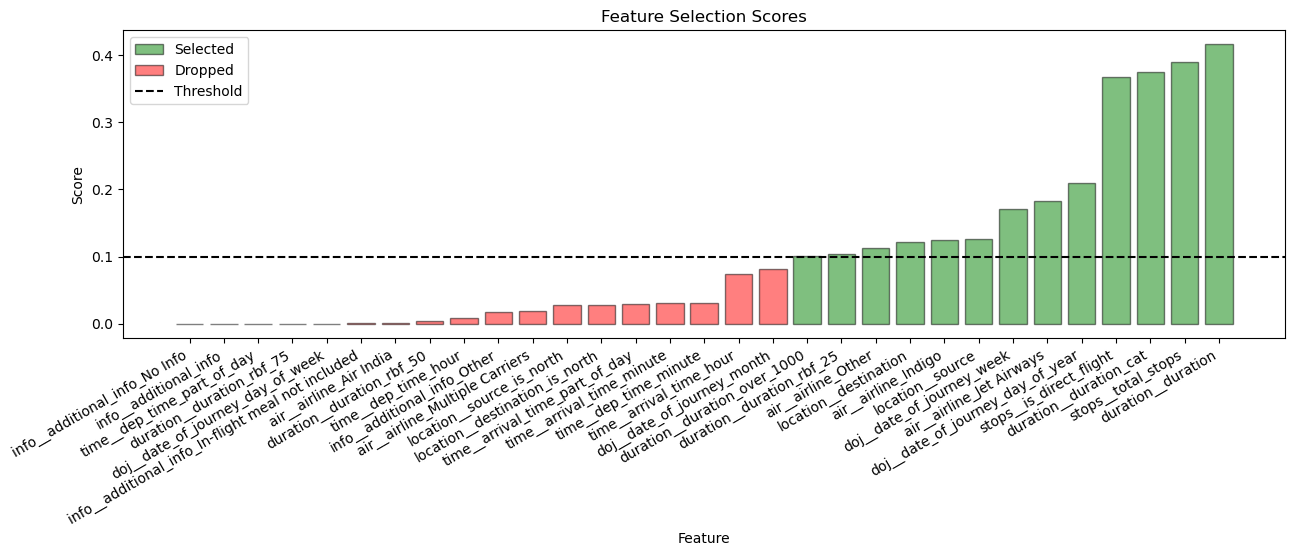

In [110]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

- The dataset went upto 31 columns after Feature Engineering
- The Feature Selection algorithm selected 13 features out of that